# Hair style segmentation (part 1 of hairstyle swap)

## Set up Google Colab

In [0]:
%ls

In [0]:
from google.colab import drive 
drive.mount("bdrive")

In [0]:
cd bdrive/My\ Drive/app/Hair-segmentation/

In [0]:
from PIL import Image
Image.open(open("images/works.jpg", "rb"))

In [0]:
!pip install torch torchvision

## Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.misc
import random 

import torch
import torch.nn as nn
import torch.functional as F
from torch import optim
from torch.utils.data import Dataset

from torchvision import models, transforms, utils
from torchvision.models.vgg import VGG

## Data 

### Load dataset

In [0]:
import random

class PartLFW(Dataset):
  
  def __init__(self, csv_file, phase):
    self.phase = phase
    self.data = pd.read_csv(csv_file)
    
  def __getitem__(self, index):
    image, label = self.data.iloc[index, 0], self.data.iloc[index, 1]
    image = scipy.misc.imread(image, mode='RGB')
    label = np.load(label)
    
    # Normalization 
    mean = [29.24429131, 29.24429131, 29.24429131]
    std = [69.8833313, 63.37436676, 61.38568878]
    
    image = np.transpose(image, (2, 0, 1)) / 255.
    image[0] = (image[0] - mean[0]) / std[0]
    image[1] = (image[1] - mean[1]) / std[1]
    image[2] = (image[2] - mean[2]) / std[2]    
   
    # ToTensor
    image = torch.from_numpy(image).float()
    label = torch.from_numpy(label).long()
       
    # One-hot encoding 
    h, w = label.size()
    target = torch.zeros(3, h, w) 
    for c in range(3):
      target[c][label == c] = 1
      
    return {'x': image, 'y':target, 'l':label}
    
  def __len__(self):
    return len(self.data)
  
train_data = PartLFW("data/LFW/training.csv", phase="train")
valid_data = PartLFW("data/LFW/validation.csv", phase="valid")
test_data = PartLFW("data/LFW/test.csv", phase="test")

trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=1)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1)

### Visualize dataset sample

torch.Size([8, 3, 500, 500]) torch.Size([8, 3, 500, 500]) torch.Size([8, 500, 500])


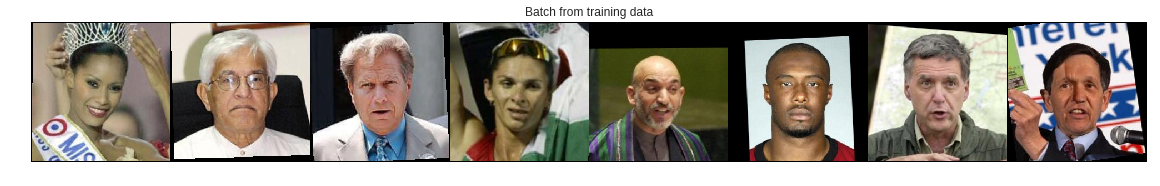

In [60]:
def show_batch(batch):
  mean = [29.24429131, 29.24429131, 29.24429131]
  std = [69.8833313, 63.37436676, 61.38568878]
  
  img_batch = batch['x']
 
  # Desnormalize 
  img_batch[:,0,...].mul_(std[0]).add_(mean[0])
  img_batch[:,1,...].mul_(std[1]).add_(mean[1])
  img_batch[:,2,...].mul_(std[2]).add_(mean[2])
  
  img_batch = np.clip(img_batch, 0, 1)
  grid = utils.make_grid(img_batch)
  
  plt.rcParams['figure.figsize'] = [20, 7.0]
  plt.figure()
  plt.title('Batch from training data')
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.axis('off')
  plt.ioff()
  plt.show
    
batch = next(iter(trainloader))
print(batch['x'].size(), batch['y'].size(), batch['l'].size())
show_batch(batch)

## Model

### Encoder 

In [0]:
class VGG16(VGG):
  
  def __init__(self, pretrained=True, requires_grad=True, remove_fc=True, padding=True, show_params=False):
    super().__init__(self.make_layers())
        
    if pretrained:
      exec("self.load_state_dict(models.vgg16(pretrained=True).state_dict())")
    if not requires_grad:
      for parameter in super().parameters():
        parameter.requires_grad = False
    if remove_fc: 
      del self.classifier
    if padding:
      self.features[0] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=100)
    if show_params:
      for name, parameter in self.named_parameters():
        print(name, parameter.size())
        
  def forward(self, x):
    ranges = ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))
    output = {}
    for idx in range(len(ranges)):
      for layer in range(ranges[idx][0], ranges[idx][1]):
        x = self.features[layer](x)
      output["pool%d"%(idx+1)] = x
    
    return output 
  
  def make_layers(self, batch_norm=False):
    cfg = [64, 64, 'M',
           128, 128, 'M', 
           256, 256, 256, 'M', 
           512, 512, 512, 'M', 
           512, 512, 512, 'M']
    layers = []
    in_channels = 3
    for v in cfg:
      if v == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
        if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
        else:
          layers += [conv2d, nn.ReLU(inplace=True)]
        in_channels = v
    return nn.Sequential(*layers)

### Decoder 

In [0]:
class FCN8s(nn.Module):
  
  def __init__(self, pretrained_model, n_classes):
    super().__init__()
    
    self.n_classes = n_classes
    self.pretrained_model = pretrained_model
    
    # fc6 of VGG16
    self.fc6 = nn.Conv2d(512, 512, 7)
    self.relu6 = nn.ReLU(inplace=True)
    self.drop6 = nn.Dropout2d()
    
    # fc7 of VGG16 
    self.fc7 = nn.Conv2d(512, 4096, 1)
    self.relu7 = nn.ReLU(inplace=True)
    self.drop7 = nn.Dropout2d()
    
    # Convolutional score layer 
    self.score_fr = nn.Conv2d(4096, n_classes, 1)
    
    # Upsampling (Deconvolutions)
    self.score_pool3 = nn.Conv2d(256, n_classes, 1)
    self.score_pool4 = nn.Conv2d(512, n_classes, 1)
    
    self.upscore2 = nn.ConvTranspose2d(n_classes, n_classes,  4, stride=2, bias=False)
    self.upscore8 = nn.ConvTranspose2d(n_classes, n_classes, 16, stride=8, bias=False)
    
    self.upscore_pool4 = nn.ConvTranspose2d(n_classes, n_classes, 4, stride=2, bias=False)
  
  def forward(self, x):
    img = x
    x = self.pretrained_model(x)
    
    # Skip connections (connect the output of one layer to a non-adjacent layer)
    pool_5 = x['pool5']
    pool_4 = x['pool4']
    pool_3 = x['pool3']
    
    x = self.relu6(self.fc6(pool_5))
    x = self.drop6(x)
    
    x = self.relu7(self.fc7(x))
    x = self.drop7(x)
    
    x = self.score_fr(x)
    x = self.upscore2(x)
    upscore2 = x
        
    x = self.score_pool4(pool_4)
    x = x[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
    score_pool4 = x
    
    x = upscore2 + score_pool4
    x = self.upscore_pool4(x)
    upscore_pool4 = x
    
    x = self.score_pool3(pool_3)
    x = x[:, :, 9:9 + upscore_pool4.size()[2], 9:9 + upscore_pool4.size()[3]]
    score_pool3 = x
    
    x = upscore_pool4 + score_pool3
    
    x = self.upscore8(x)
    
    x = x[:, :, 31:31 + img.size()[2], 31:31 + img.size()[3]].contiguous()
    
    return x

### Test shapes

In [30]:
batch, n_classes, height, width = 1, 3, 500, 500

model = FCN8s(VGG16(), n_classes)
model.to(device)

input_img = torch.rand(batch, n_classes, height, width)
out_pred = model(input_img.to(device))

assert out_pred.size() == torch.Size([batch, n_classes, height, width])
print("correct shapes")


correct shapes


## Train FCN

### Evaluation functions

In [0]:
def iou(y_hat, y):
  ious = []
  for c in range(n_classes):
    pred_inds = y_hat == c
    target_inds = y == c
    intersection = pred_inds[target_inds].sum()
    union = pred_inds.sum() + target_inds.sum() - intersection
    if union == 0:
      ious.append(float('nan')) # If there is no ground truth, do not include in evaluation
    else:
      ious.append(float(intersection) / max(union, 1))
  return ious

def pixel_accuracy(y_hat, y):
  correct = (y_hat == y).sum()
  total = (y == y).sum()
  return correct/total


def validation(model, validloader, criterion):
  total_ious = []
  pixel_accs = []
  for i, batch in enumerate(validloader):
    inputs = batch['x'].to(device)
    output = model(inputs)
    output = output.data.cpu().numpy()
        
    N, _, h, w = output.shape 
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_classes).argmax(axis=1).reshape(N, h, w)
    target = batch['l'].cpu().numpy().reshape(N, h, w)
    
    for y_hat, y in zip(pred, target):
      total_ious.append(iou(y_hat, y))
      pixel_accs.append(pixel_accuracy(y_hat, y))
  
  # Pixel accuracy
  pixel_acc = np.array(pixel_accs).mean()
  
  # Mean IoU
  total_ious = np.array(total_ious).T
  mean_iou = np.nanmean(np.nanmean(total_ious, axis=1))
  
  return pixel_acc, mean_iou

### Parameters

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define model
n_classes = 3
model = FCN8s(VGG16(), n_classes)
model.to(device)

# Define training parameters
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, momentum=0, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
epochs = 1
print_every = 5

### Accuracy before training

In [33]:
model.eval()
with torch.no_grad():
  pixel_acc, mean_iou = validation(model, validloader, criterion)
model.train()
print("Pixel accuracy: ", pixel_acc, " Mean IoU: ", mean_iou)

Pixel accuracy:  0.3071848  Mean IoU:  0.16083074420278123


### Train

In [13]:
best = 0
for epoch in range(epochs):
  for i, batch in enumerate(trainloader):
    inputs, labels = batch['x'].to(device), batch['y'].to(device)
    optimizer.zero_grad()
    
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if i % print_every == 0:
      model.eval()
      with torch.no_grad():
        paccuracy, meaniou = validation(model, validloader, criterion)
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training loss: {:.5f}.. ".format(loss.item()),
              "Pixel accuracy.. {:.5f}".format(paccuracy),
              "Mean IU.. {:.5f}".format(meaniou))
      if best < paccuracy:
        torch.save(model.state_dict(), "./fcn-model-bestacc2.pth")
        best = paccuracy
      model.train()

Epoch: 1/1..  Training loss: 0.69329..  Pixel accuracy.. 0.36550 Mean IU.. 0.18209
Epoch: 1/1..  Training loss: 0.64029..  Pixel accuracy.. 0.58337 Mean IU.. 0.23351
Epoch: 1/1..  Training loss: 0.59811..  Pixel accuracy.. 0.63271 Mean IU.. 0.23252
Epoch: 1/1..  Training loss: 0.61589..  Pixel accuracy.. 0.66258 Mean IU.. 0.22913
Epoch: 1/1..  Training loss: 0.49765..  Pixel accuracy.. 0.67315 Mean IU.. 0.22828
Epoch: 1/1..  Training loss: 0.48015..  Pixel accuracy.. 0.68052 Mean IU.. 0.22691
Epoch: 1/1..  Training loss: 0.49102..  Pixel accuracy.. 0.67979 Mean IU.. 0.22670
Epoch: 1/1..  Training loss: 0.47249..  Pixel accuracy.. 0.68099 Mean IU.. 0.22706
Epoch: 1/1..  Training loss: 0.47756..  Pixel accuracy.. 0.68114 Mean IU.. 0.22710
Epoch: 1/1..  Training loss: 0.47073..  Pixel accuracy.. 0.68060 Mean IU.. 0.22693
Epoch: 1/1..  Training loss: 0.46062..  Pixel accuracy.. 0.68623 Mean IU.. 0.24138
Epoch: 1/1..  Training loss: 0.45614..  Pixel accuracy.. 0.68268 Mean IU.. 0.22758
Epoc

In [0]:
#torch.save(model.state_dict(), "./fcn-model.pth")

In [15]:
model.eval()
with torch.no_grad():
  pixel_acc, mean_iou = validation(model, validloader, criterion)
model.train()
print("Pixel accuracy: ", pixel_acc, " Mean IoU: ", mean_iou)

Pixel accuracy:  0.840806696  Mean IoU:  0.5082801272644512


In [52]:
model.eval()
with torch.no_grad():
  pixel_acc, mean_iou = validation(model, testloader, criterion)
model.train()
print("Pixel accuracy: ", pixel_acc, " Mean IoU: ", mean_iou)

Pixel accuracy:  0.8445634951456311  Mean IoU:  0.5116770614689133
